In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import maskrcnn_resnet50_fpn

from PIL import Image

设置 torch.device。

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

从数据集中随机选择一张图片，分别使用 Faster R-CNN 和 Mask R-CNN 处理。这里采用 VOC2012 数据集。

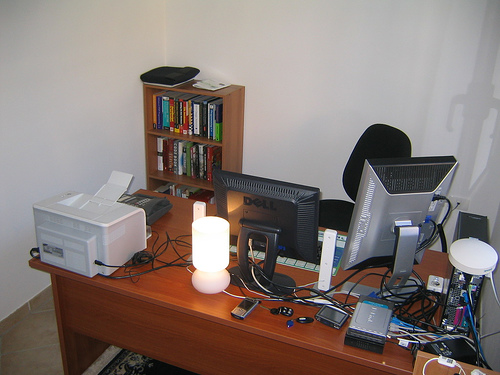

In [3]:
voc_path = "./data/VOCdevkit/VOC2012"
image_set = 'train'
# 读取图像列表
with open(os.path.join(voc_path, 'ImageSets', 'Main', f'{image_set}.txt')) as f:
    image_list = f.read().splitlines()

# 随机选择一个图像
random_image = random.choice(image_list)
img_pil = Image.open(os.path.join(voc_path, 'JPEGImages', f'{random_image}.jpg')).convert('RGB')
# 展示图像
img_pil

In [4]:
# 预处理图像
img_transform = T.Compose(
    [T.ToTensor()]
)

img = img_transform(img_pil).unsqueeze(0)
img = img.to(device)
img

tensor([[[[0.5098, 0.5176, 0.5098,  ..., 0.4863, 0.4824, 0.4745],
          [0.5137, 0.5294, 0.5216,  ..., 0.4980, 0.4902, 0.4863],
          [0.5255, 0.5294, 0.5294,  ..., 0.4980, 0.4941, 0.4902],
          ...,
          [0.2745, 0.2706, 0.2824,  ..., 0.4588, 0.4235, 0.3882],
          [0.2667, 0.2627, 0.2784,  ..., 0.4745, 0.4706, 0.4667],
          [0.2627, 0.2627, 0.2706,  ..., 0.4745, 0.4706, 0.4667]],

         [[0.5294, 0.5373, 0.5294,  ..., 0.5020, 0.4863, 0.4784],
          [0.5333, 0.5373, 0.5294,  ..., 0.5059, 0.4980, 0.4863],
          [0.5333, 0.5373, 0.5294,  ..., 0.4980, 0.4941, 0.4902],
          ...,
          [0.2667, 0.2549, 0.2510,  ..., 0.3176, 0.3059, 0.3020],
          [0.2588, 0.2471, 0.2471,  ..., 0.3294, 0.3176, 0.3020],
          [0.2549, 0.2392, 0.2431,  ..., 0.3412, 0.3373, 0.3255]],

         [[0.5137, 0.5216, 0.5059,  ..., 0.5059, 0.4941, 0.4863],
          [0.5176, 0.5255, 0.5098,  ..., 0.5020, 0.4941, 0.4863],
          [0.5216, 0.5255, 0.5216,  ..., 0

In [5]:
# 加载预训练的 Faster R-CNN 和 Mask R-CNN 模型
faster_rcnn_model = fasterrcnn_resnet50_fpn(weights=True)
mask_rcnn_model = maskrcnn_resnet50_fpn(weights=True)

faster_rcnn_model.cuda()
mask_rcnn_model.cuda()

# 将模型置为 eval 模式
faster_rcnn_model.eval()
mask_rcnn_model.eval()

/home/asuna/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/asuna/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [6]:
# 使用模型进行目标检测
with torch.no_grad():
    faster_rcnn_pred = faster_rcnn_model(img)
    mask_rcnn_pred = mask_rcnn_model(img)

可视化结果

In [7]:
# COCO 数据集标签对照表。PyTorch 的 Faster R-CNN 和 Mask R-CNN 模型是在 COCO 数据集上训练的，需要对标签进行映射
COCO_CLASSES = {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
                6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
                11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench',
                16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow',
                22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack',
                28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee',
                35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat',
                40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket',
                44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon',
                51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange',
                56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut',
                61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table',
                70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard',
                77: 'cell phone', 78: 'microwave', 79: 'oven', 80: 'toaster', 81: 'sink',
                82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase', 87: 'scissors',
                88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'}

COLORS = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
          '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
          '#ffd8b1', '#e6beff', '#808080']


def get_label(label: str):
    return COCO_CLASSES[label]


def show_result(pred, img, confidence_threshold: float = 0.8):
    for box, score, label in zip(pred[0]['boxes'], pred[0]['scores'], pred[0]['labels']):
        if score > confidence_threshold:
            box = box.cpu().numpy().astype(int)
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
            cv2.putText(img, get_label(label.item()), (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (255, 0, 0), 2)

In [8]:
faster_rcnn_img = np.array(img_pil)
mask_rcnn_img = np.array(img_pil)

show_result(faster_rcnn_pred, faster_rcnn_img)
show_result(mask_rcnn_pred, mask_rcnn_img)

作图对比两种模型的检测结果。

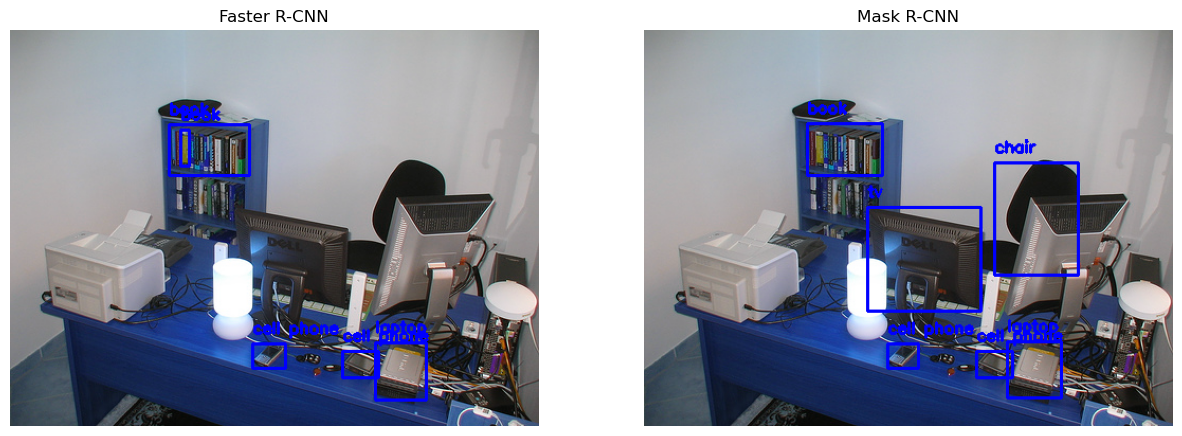

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 30))
# Faster R-CNN
axes[0].imshow(cv2.cvtColor(faster_rcnn_img, cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title("Faster R-CNN")
# Mask R-CNN
axes[1].imshow(cv2.cvtColor(mask_rcnn_img, cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title("Mask R-CNN")
# 对比图
plt.show()